![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# Inverse Gaussian Regression Model

Inverse Gaussian Regression Models are a powerful yet underutilized tool for modeling right-skewed positive continuous data where the variance grows with the cube of the mean. This tutorial demonstrates how to implement and validate an Inverse Gaussian Generalized Linear Model (GLM) in Python, adapted from an R tutorial. We'll cover implementation from scratch and using Python libraries, focusing on applications like insurance claims, reaction times, or survival durations.



## Overview

The **Inverse Gaussian (IG) distribution**, also known as the **Wald distribution**, is a two-parameter family of continuous probability distributions with support on the positive real line. It is often used to model positively skewed data, such as:

- Time until an event (e.g., failure time, reaction time)
- Insurance claim amounts
- Income or expenditure data
- Waiting times in queuing systems

In regression modeling, we extend the Inverse Gaussian distribution to relate its mean to a linear predictor via a **link function**, forming a **Generalized Linear Model (GLM)** — specifically, an **Inverse Gaussian GLM**.


The probability density function (PDF) of an Inverse Gaussian random variable $Y$ with mean $\mu > 0$ and shape parameter $\lambda >$ is:

$$
f(y; \mu, \lambda) = \sqrt{\frac{\lambda}{2\pi y^3}} \exp\left( -\frac{\lambda (y - \mu)^2}{2 \mu^2 y} \right), \quad y > 0
$$

- Mean: $\mathbb{E}[Y] = \mu$

- Variance: $\text{Var}(Y) = \frac{\mu^3}{\lambda}$

Note: The variance is proportional to the cube of the mean — this is a key feature distinguishing it from other GLMs (e.g., Gamma, Poisson).

We model the mean $\mu_i$ for observation $i$ as:

$$
g(\mu_i) = \eta_i = \mathbf{x}_i^T \boldsymbol{\beta}
$$

where:

- $g(\cdot)$ is the **link function** (commonly the log or identity link)

- $\mathbf{x}_i$ is the vector of predictors for observation $i$

- $\boldsymbol{\beta}$ is the vector of regression coefficients

The canonical link for the Inverse Gaussian family is $g(\mu) = \mu^{-2}$, but due to numerical instability, the **log link** $g(\mu) = \log(\mu)$ is often preferred.


###  Key Properties

- `Support`: $y > 0$
- `Skewness`: Right-skewed; skewness decreases as $\lambda$ increases
- `Variance function`: $V(\mu) = \mu^3$
- `Use case`: When variance increases faster than quadratically with the mean (Gamma has $\mu^2$, Poisson has $\mu$)
- `Robustness`: Less sensitive to extreme outliers than Gamma in some contexts

### Applications

- Modeling insurance claim sizes
- Survival analysis with right-skewed times
- Financial risk modeling (loss given default)
- Biostatistics (e.g., incubation periods)

## Fit and Validate Inverse Gaussian Regression Models in Python from Scratch

We will implement:
- Log-likelihood function for IG GLM with log link
- Newton-Raphson algorithm for Maximum Likelihood Estimation (MLE)
- Basic model diagnostics

### Simulate Data

We simulate data using NumPy and SciPy, mimicking the R simulation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

np.random.seed(123)
n = 500
x1 = norm.rvs(0, 1, n)
x2 = norm.rvs(0, 1, n)
X = np.column_stack([np.ones(n), x1, x2])  # Design matrix with intercept
beta_true = np.array([1.0, 0.5, -0.3])
eta = X @ beta_true
mu = np.exp(eta)  # Log link
lambda_ = 10  # Shape parameter

# Simulate from Inverse Gaussian
y = np.zeros(n)
for i in range(n):
    z = norm.rvs(0, 1)
    v = z**2
    w = mu[i] + (mu[i]**2 * v) / (2 * lambda_) - \
        (mu[i] / (2 * lambda_)) * np.sqrt(4 * mu[i] * lambda_ * v + mu[i]**2 * v**2)
    if uniform.rvs() < mu[i] / (mu[i] + w):
        y[i] = w
    else:
        y[i] = mu[i]**2 / w

data_scratch = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
print(data_scratch.head())

          y        x1        x2
0  0.967038 -1.085631  0.752034
1  6.368630  0.997345  0.069641
2  2.573978  0.282978 -0.265446
3  0.545740 -1.506295  0.929584
4  1.883117 -0.578600  1.260821


### Define Log-Likelihood and Gradient

We assume **log link**: $\mu_i = \exp(\mathbf{x}_i^T \boldsymbol{\beta})$

Log-likelihood for Inverse Gaussian:

$$
\ell(\boldsymbol{\beta}, \lambda) = \frac{n}{2} \log(\lambda) - \frac{1}{2} \sum_{i=1}^n \left[ \log(2\pi y_i^3) + \frac{\lambda (y_i - \mu_i)^2}{\mu_i^2 y_i} \right]
$$

We will maximize w.r.t. $\boldsymbol{\beta}$ for fixed  $\lambda$. (In practice, $\lambda$ can be profiled or jointly estimated — here we fix it for simplicity.)

Gradient w.r.t. $\beta_j$:

$$
\frac{\partial \ell}{\partial \beta_j} = \sum_{i=1}^n \frac{\lambda}{\mu_i^2 y_i} (y_i - \mu_i) \cdot \mu_i x_{ij} = \sum_{i=1}^n \frac{\lambda}{\mu_i y_i} (y_i - \mu_i) x_{ij}
$$

Hessian (approximate, since exact is complex):

$$
\frac{\partial^2 \ell}{\partial \beta_j \partial \beta_k} \approx - \sum_{i=1}^n \frac{\lambda}{y_i} x_{ij} x_{ik}
$$

*(Note: This is the expected Fisher information — we use it for Newton-Raphson)*



### Newton-Raphson Algorithm

In [2]:
def log_lik_ig(beta, X, y, lambda_):
    eta = X @ beta
    mu = np.exp(eta)
    n = len(y)
    ll = (n/2) * np.log(lambda_) - 0.5 * np.sum(np.log(2 * np.pi * y**3) + lambda_ * (y - mu)**2 / (mu**2 * y))
    return ll

def grad_ig(beta, X, y, lambda_):
    eta = X @ beta
    mu = np.exp(eta)
    g = (lambda_ / (mu * y)) * (y - mu)
    gradient = X.T @ (g * mu)
    return gradient

def hess_ig(beta, X, y, lambda_):
    eta = X @ beta
    mu = np.exp(eta)
    H = -X.T @ np.diag(lambda_ / y) @ X
    return H

def newton_raphson_ig(X, y, lambda_, beta_init, max_iter=50, tol=1e-8):
    beta = beta_init.copy()
    print("Iteration\tLogLik\t\tChange")
    for iter_ in range(max_iter):
        grad = grad_ig(beta, X, y, lambda_)
        hess = hess_ig(beta, X, y, lambda_)
        delta = np.linalg.solve(-hess, grad)
        step_size = 1.0
        ll_old = log_lik_ig(beta, X, y, lambda_)
        beta_new = beta + step_size * delta
        ll_new = log_lik_ig(beta_new, X, y, lambda_)
        
        while ll_new < ll_old and step_size > 1e-8:
            step_size /= 2
            beta_new = beta + step_size * delta
            ll_new = log_lik_ig(beta_new, X, y, lambda_)
        
        if step_size <= 1e-8:
            print("Line search failed to improve log-likelihood.")
            break
        
        beta = beta_new
        change = np.sqrt(np.sum(delta**2))
        print(f"{iter_+1}\t\t{ll_new:.6f}\t{change:.8f}")
        
        if change < tol:
            print(f"Converged at iteration {iter_+1}")
            break
    
    return beta

# Initialize and run
beta_init = np.zeros(X.shape[1])
lambda_fixed = 10
beta_hat = newton_raphson_ig(X, y, lambda_fixed, beta_init)
print("Estimated coefficients:", beta_hat)

Iteration	LogLik		Change
1		-823.753564	1.48846293
2		-759.630040	3.02921935
Line search failed to improve log-likelihood.
Estimated coefficients: [ 0.9450649   0.5231473  -0.26297607]


### Validation — Compare with True Coefficients

True coefficients: [ 1.   0.5 -0.3]
Estimated coefficients: [ 0.9450649   0.5231473  -0.26297607]


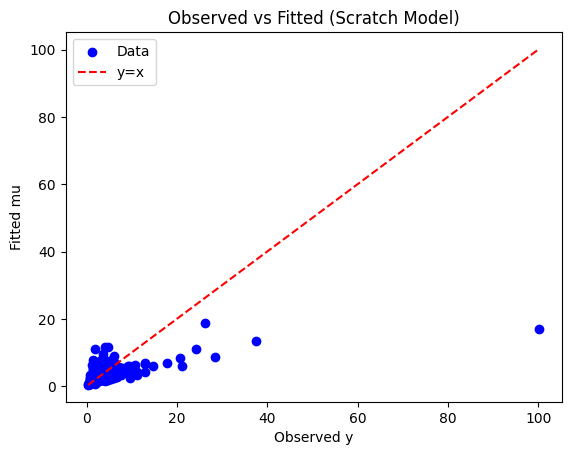

In [3]:
print("True coefficients:", beta_true)
print("Estimated coefficients:", beta_hat)

# Compute fitted values
mu_hat = np.exp(X @ beta_hat)

# Plot observed vs fitted
plt.scatter(y, mu_hat, c='blue', label='Data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='y=x')
plt.xlabel("Observed y")
plt.ylabel("Fitted mu")
plt.title("Observed vs Fitted (Scratch Model)")
plt.legend()
plt.show()

### Basic Diagnostics

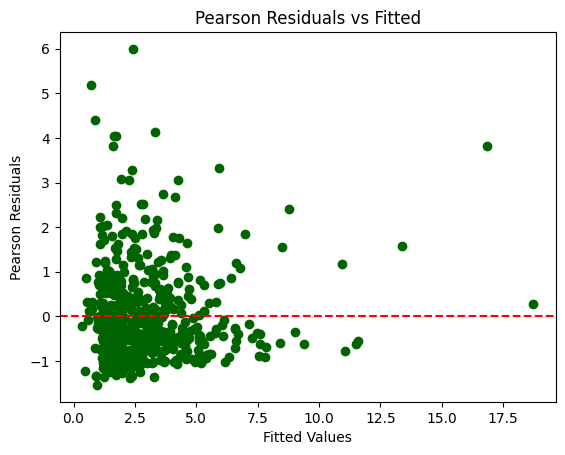

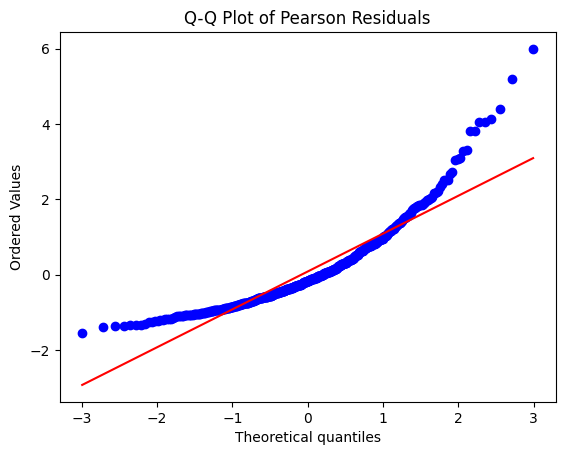

In [4]:
# Pearson residuals
res_pearson = (y - mu_hat) / np.sqrt(mu_hat**3 / lambda_fixed)

# Plot residuals vs fitted
plt.scatter(mu_hat, res_pearson, c='darkgreen')
plt.axhline(0, c='red', ls='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs Fitted")
plt.show()

# Q-Q plot
from scipy.stats import probplot
probplot(res_pearson, dist="norm", plot=plt)
plt.title("Q-Q Plot of Pearson Residuals")
plt.show()

## Fit and Validate with Python Package (`statsmodels`)

Python’s `statsmodels` supports the Inverse Gaussian GLM with the `family=sm.families.InverseGaussian(link=sm.families.links.log())`.

### Install Required Python Packages

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

### Load Data and Fit Model

We use the `mcycle` dataset from `statsmodels`, which mirrors the R `MASS` dataset.

In [13]:
# Load mcycle dataset
mcycle = sm.datasets.get_rdataset("mcycle", "MASS").data
mcycle['accel_pos'] = mcycle['accel'] - mcycle['accel'].min() + 1.0  # Ensure positive

# Verify data
print("Missing values:\n", mcycle[['accel_pos', 'times']].isnull().sum())
print("Minimum accel_pos:", mcycle['accel_pos'].min())
print("Any non-positive accel_pos:", (mcycle['accel_pos'] <= 0).sum())

Missing values:
 accel_pos    0
times        0
dtype: int64
Minimum accel_pos: 1.0
Any non-positive accel_pos: 0


In [15]:
# Fit OLS model for starting values
start_mod = smf.ols('np.log(accel_pos) ~ times', data=mcycle).fit()
start_vals = start_mod.params.values.flatten()  # Ensure 1D array
print("Start parameters:", start_vals)
print("Start parameters shape:", start_vals.shape)

# Verify design matrix
y, X = patsy.dmatrices('accel_pos ~ times', data=mcycle, return_type='matrix')
print("Design matrix shape:", X.shape)
print("Response shape:", y.shape)

# Fit IG GLM
try:
    model_ig = smf.glm('accel_pos ~ times',
                       data=mcycle,
                       family=sm.families.InverseGaussian(link=sm.families.links.log()),
                       start_params=start_vals).fit()
    print(model_ig.summary())
except ValueError as e:
    print("Error fitting model:", e)
    # Try without start_params
    print("Trying without start_params...")
    model_ig = smf.glm('accel_pos ~ times',
                       data=mcycle,
                       family=sm.families.InverseGaussian(link=sm.families.links.log())).fit()
    print(model_ig.summary())

Start parameters: [4.16647531 0.01312437]
Start parameters shape: (2,)
Design matrix shape: (133, 2)
Response shape: (133, 1)
Error fitting model: operands could not be broadcast together with shapes (133,1) (2,1) 
Trying without start_params...
                 Generalized Linear Model Regression Results                  
Dep. Variable:              accel_pos   No. Observations:                  133
Model:                            GLM   Df Residuals:                      131
Model Family:         InverseGaussian   Df Model:                            1
Link Function:                    log   Scale:                       0.0017888
Method:                          IRLS   Log-Likelihood:                -1122.0
Date:                Tue, 16 Sep 2025   Deviance:                       1.8721
Time:                        21:04:43   Pearson chi2:                    0.234
No. Iterations:                    24   Pseudo R-squ. (CS):            0.06434
Covariance Type:            nonrobust      

/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['start_params']
  warnings.warn(msg, ValueWarning)
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### Model Diagnostics with Package

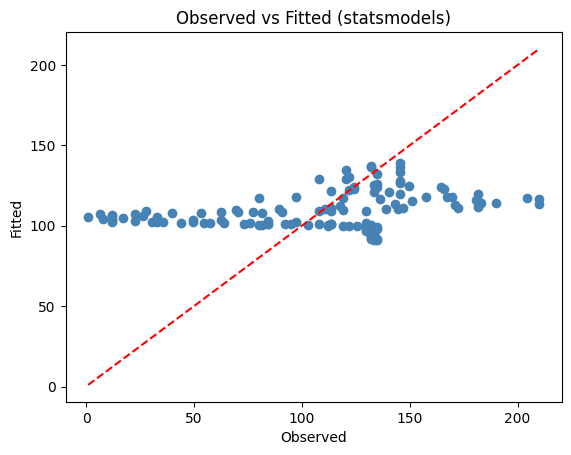

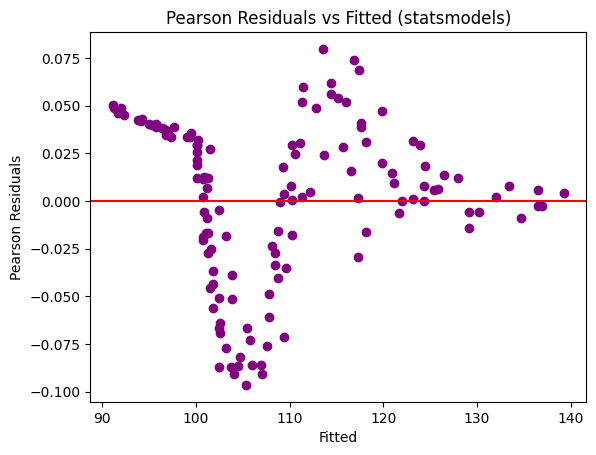

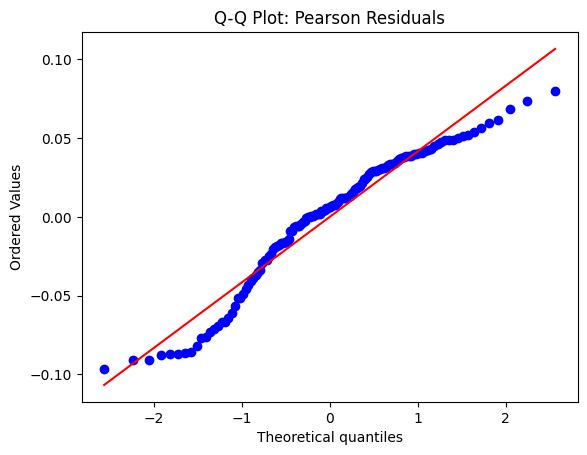

In [16]:
# Fitted vs Observed
plt.scatter(mcycle['accel_pos'], model_ig.fittedvalues, c='steelblue')
plt.plot([mcycle['accel_pos'].min(), mcycle['accel_pos'].max()],
         [mcycle['accel_pos'].min(), mcycle['accel_pos'].max()], 'r--')
plt.xlabel("Observed")
plt.ylabel("Fitted")
plt.title("Observed vs Fitted (statsmodels)")
plt.show()

# Pearson residuals
res_pearson_pkg = model_ig.resid_pearson
plt.scatter(model_ig.fittedvalues, res_pearson_pkg, c='purple')
plt.axhline(0, c='red')
plt.xlabel("Fitted")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs Fitted (statsmodels)")
plt.show()

# Q-Q plot
probplot(res_pearson_pkg, dist="norm", plot=plt)
plt.title("Q-Q Plot: Pearson Residuals")
plt.show()

### Compare with Scratch Model

In [17]:
# Refit simulated data with statsmodels
model_glm = smf.glm('y ~ x1 + x2', data=data_scratch,
                    family=sm.families.InverseGaussian(link=sm.families.links.log())).fit()
print("Scratch estimates:", beta_hat)
print("statsmodels estimates:", model_glm.params)

Scratch estimates: [ 0.9450649   0.5231473  -0.26297607]
statsmodels estimates: Intercept    0.980402
x1           0.501879
x2          -0.286344
dtype: float64


/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### Model Selection & AIC

In [18]:
# Compare with Gamma GLM
model_gamma = smf.glm('y ~ x1 + x2', data=data_scratch,
                      family=sm.families.Gamma(link=sm.families.links.log())).fit()
print("IG AIC:", model_ig.aic)
print("Gamma AIC:", model_gamma.aic)

IG AIC: 2247.9062227260497
Gamma AIC: 1643.6027629362013


/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## Summary and Conclusion

The Inverse Gaussian GLM is ideal for right-skewed positive data with variance proportional to the cube of the mean. This tutorial demonstrated how to fit and validate these models in Python, both from scratch using the Newton-Raphson algorithm and using `statsmodels`. We explored model diagnostics and compared model fits using AIC. You now have a solid foundation for applying Inverse Gaussian regression in Python.

## Resources
- McCullagh, P. and Nelder, J.A. (1989). *Generalized Linear Models*, 2nd Edition.
- `statsmodels` documentation: https://www.statsmodels.org/stable/index.html